В практической части вебинара на простых примерах реализуем рассмотренные теоретические аспекты:


1.   RFM-анализ на транзакционных данных
2.   Кластеризация K-means
3.   Кластеризация DBSCAN
4.   Логистическая регрессия для сегментации



# RFM-анализ

Для примера используем данные с https://www.kaggle.com/code/regivm/rfm-analysis-tutorial/input?select=Retail_Data_Transactions.csv

Датасет содержит данные о транзакциях на уровне клиента по дате.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

In [2]:
def plot_distrib(df):
  # Построение распределений для каждой колонки
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  # Распределение для Recency
  sns.histplot(df['Recency'], kde=True, color='blue', ax=axes[0])
  axes[0].set_title('Distribution of Recency')
  axes[0].set_xlabel('Recency')
  axes[0].set_ylabel('Frequency')

  # Распределение для Frequency
  sns.histplot(df['Frequency'], kde=True, color='green', ax=axes[1])
  axes[1].set_title('Distribution of Frequency')
  axes[1].set_xlabel('Frequency')
  axes[1].set_ylabel('Frequency')

  # Распределение для Monetary
  sns.histplot(df['Monetary'], kde=True, color='red', ax=axes[2])
  axes[2].set_title('Distribution of Monetary')
  axes[2].set_xlabel('Monetary')
  axes[2].set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()

Загружаем данные, сразу считывая даты в нужном формате:

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/OTUS/Retail_Data_Transactions.csv', parse_dates=['trans_date'])
print(df.shape)
df.head()

(125000, 3)


,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [4]:
print("Нам даны транзакции за интервал:")
print(df['trans_date'].min(), df['trans_date'].max())

Нам даны транзакции за интервал:
2011-05-16 00:00:00 2015-03-16 00:00:00


RFM-анализ требует провести разбиение данных пол сумме, количеству и "давности" транзакций. Сумма у нас есть, количество посчитаем позже группировкой. Не хватает "давности":

In [5]:
sd = dt.datetime(2015,4,1)
df['days_from_last_transaction'] = (sd - df['trans_date']).dt.days
# возьмем транзакции за год
df = df[df['days_from_last_transaction'] <= 365]
print(df.shape)
df.head()

(30928, 4)


,customer_id,trans_date,tran_amount,days_from_last_transaction
1,CS4768,2015-03-15,39,17
7,CS5902,2015-01-30,89,61
14,CS5552,2014-12-29,78,93
18,CS3904,2014-07-20,103,255
30,CS2859,2015-02-27,77,33


In [6]:
# группируем данные в необходимый формат агрегации
rfmTable = df.groupby('customer_id').agg({
    'days_from_last_transaction': lambda x: x.min(), # Recency
    'customer_id': lambda x: len(x), # Frequency
    'tran_amount': lambda x: x.sum() # Monetary Value
    })
print(rfmTable.shape)
rfmTable.head()

(6763, 3)


,days_from_last_transaction,customer_id,tran_amount
customer_id,,,
CS1112,77,4,251
CS1113,51,6,393
CS1114,48,5,315
CS1115,27,3,248
CS1116,219,3,190


In [7]:
# для удобства переименуем колонки
rfmTable.rename(columns={'days_from_last_transaction': 'Recency',
                         'customer_id': 'Frequency',
                         'tran_amount': 'Monetary'}, inplace=True)
print(rfmTable.shape)
rfmTable.head()

(6763, 3)


,Recency,Frequency,Monetary
customer_id,,,
CS1112,77,4,251
CS1113,51,6,393
CS1114,48,5,315
CS1115,27,3,248
CS1116,219,3,190


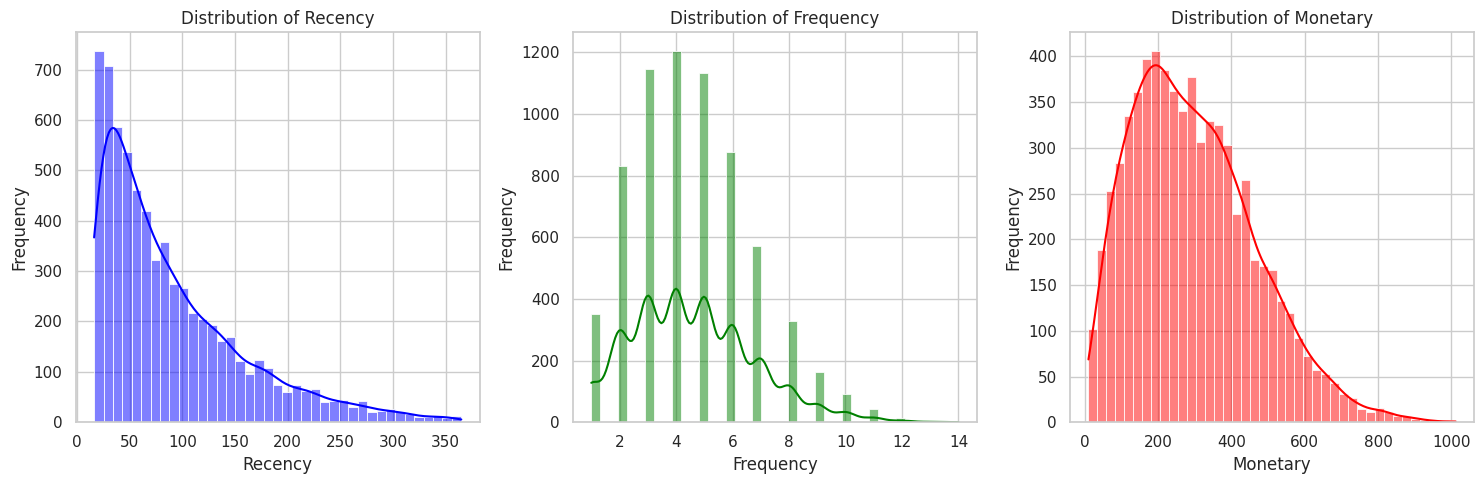

In [8]:
# распределение полученных фичей
plot_distrib(rfmTable)

In [9]:
# Присвоение баллов по квантилям
rfmTable['R_Score'] = pd.qcut(rfmTable['Recency'], 3, labels=range(1, 4))
rfmTable['F_Score'] = pd.qcut(rfmTable['Frequency'], 3, labels=range(3, 0, -1))
rfmTable['M_Score'] = pd.qcut(rfmTable['Monetary'], 3, labels=range(3, 0, -1))

In [10]:
# Объединение баллов в один RFM-балл
rfmTable['RFM_Score'] = rfmTable['R_Score'].astype(str) + rfmTable['F_Score'].astype(str) + rfmTable['M_Score'].astype(str)
print(rfmTable.shape)
rfmTable.head()

(6763, 7)


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
customer_id,,,,,,,
CS1112,77,4,251,2,2,2,222
CS1113,51,6,393,2,1,1,211
CS1114,48,5,315,2,2,2,222
CS1115,27,3,248,1,3,2,132
CS1116,219,3,190,3,3,3,333


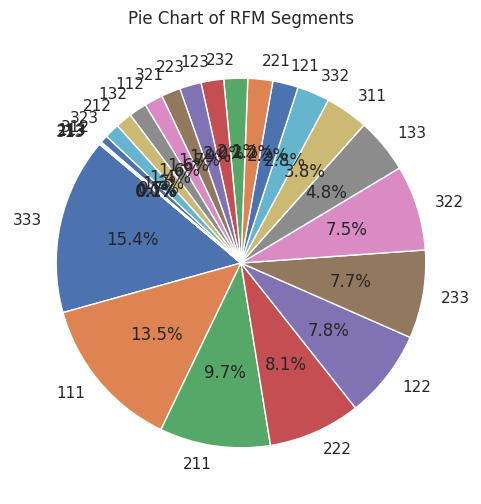

In [11]:
# Круговая диаграмма для RFM-сегментов
plt.figure(figsize=(6, 6))
rfm_counts = rfmTable['RFM_Score'].value_counts()
plt.pie(rfm_counts, labels=rfm_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of RFM Segments')
plt.show()

In [12]:
# Постоянные клиенты, которые готовы регулярно покупать на большие суммы?
rfmTable[rfmTable['RFM_Score'] == '111'][['Recency',	'Frequency',	'Monetary']].agg(['count', 'mean', 'median', 'min', 'max'])

,Recency,Frequency,Monetary
count,916.000000,916.000000,916.000000
mean,29.145197,7.424672,523.518559
median,28.000000,7.000000,504.000000
min,16.000000,6.000000,360.000000
max,46.000000,14.000000,951.000000


In [13]:
# относительно недавние клиенты, которые покупают со средней частотой на среднюю сумму?
rfmTable[rfmTable['RFM_Score'] == '322'][['Recency',	'Frequency',	'Monetary']].agg(['count', 'mean', 'median', 'min', 'max'])

,Recency,Frequency,Monetary
count,505.000000,505.000000,505.000000
mean,152.233663,4.368317,282.485149
median,143.000000,4.000000,283.000000
min,101.000000,4.000000,202.000000
max,295.000000,5.000000,359.000000


In [14]:
# самые неактивные и разовые клиенты?
rfmTable[rfmTable['RFM_Score'] == '333'][['Recency',	'Frequency',	'Monetary']].agg(['count', 'mean', 'median', 'min', 'max'])

,Recency,Frequency,Monetary
count,1044.000000,1044.000000,1044.000000
mean,193.834291,2.056513,109.831418
median,180.500000,2.000000,108.000000
min,101.000000,1.000000,10.000000
max,365.000000,3.000000,201.000000


# K-means

Для работы с этим методом есть специальная библиотека: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Датасет берем из
https://www.kaggle.com/datasets/camnugent/california-housing-prices?resource=download

Данные относятся к домам, расположенным в штате Калифорния. Это сводная статистика о недвижимости, основанная на данных переписи 1990 года.

Попытаемся кластеризовать эти данные.

In [15]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns

In [16]:
# загрузим данные
# в простом случае возьмем только три колонки
# можете проэкспериментировать с бОльшим набором данных
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/OTUS/housing.csv', usecols = ['longitude', 'latitude', 'median_house_value'])
print(df.shape)
df.head()

(20640, 3)


,longitude,latitude,median_house_value
0,-122.23,37.88,452600.0
1,-122.22,37.86,358500.0
2,-122.24,37.85,352100.0
3,-122.25,37.85,341300.0
4,-122.25,37.85,342200.0


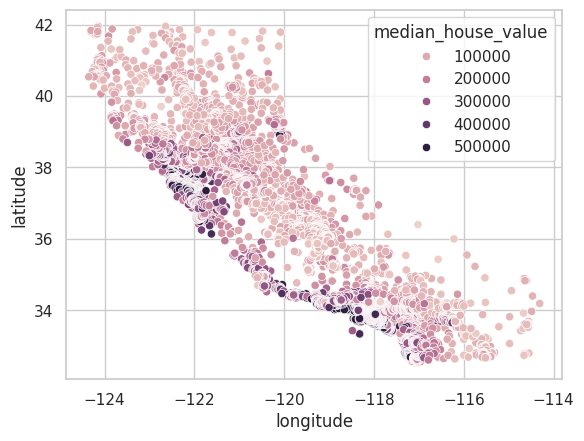

In [17]:
sns.scatterplot(data = df, x = 'longitude', y = 'latitude', hue = 'median_house_value');

In [18]:
# разделим на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(df[['latitude', 'longitude']],
                                                    df[['median_house_value']],
                                                    test_size=0.33,
                                                    random_state=42)
print(X_train.shape, X_test.shape)

(13828, 2) (6812, 2)


In [19]:
# необходимо масштабировать данные
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

In [20]:
# запустим клатеризацию на фиксированных парметрах
kmeans = KMeans(n_clusters = 3,
                random_state = 42,
                max_iter=300,
                n_init='auto')
kmeans.fit(X_train_norm)

KMeans(n_clusters=3, n_init='auto', random_state=42)

In [21]:
print('SSE: ', kmeans.inertia_)
print('silhouette', silhouette_score(X_train_norm, kmeans.labels_, metric='euclidean'))

SSE:  0.16279422179147213
silhouette 0.7498110566186849


In [22]:
# на какой итерации сошелся алогритм?
kmeans.n_iter_

5

In [23]:
kmeans.labels_[:10]

array([1, 0, 1, 0, 0, 0, 0, 1, 2, 1], dtype=int32)

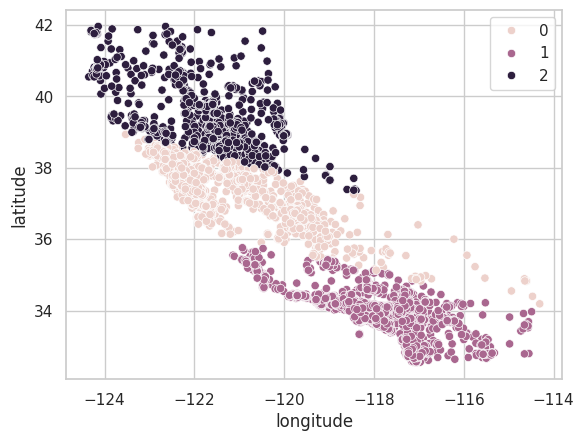

In [24]:
sns.scatterplot(data = X_train,
                x = 'longitude', y = 'latitude',
                hue = kmeans.labels_);

In [25]:
# посчитаем SSE на нескольких вариантах кластеров

kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
 }

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train_norm)
    sse.append(kmeans.inertia_)

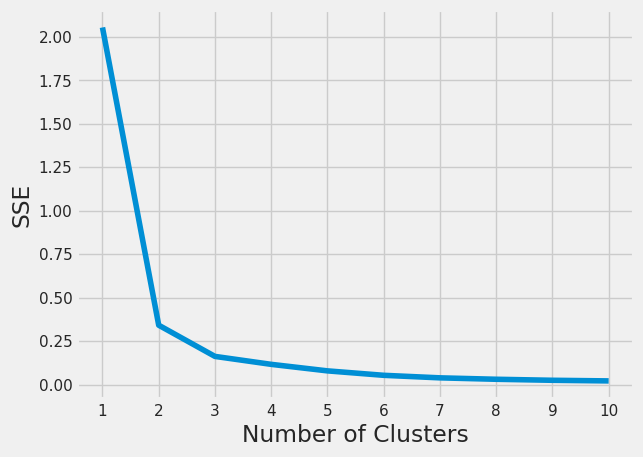

In [26]:
# метод локтя
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

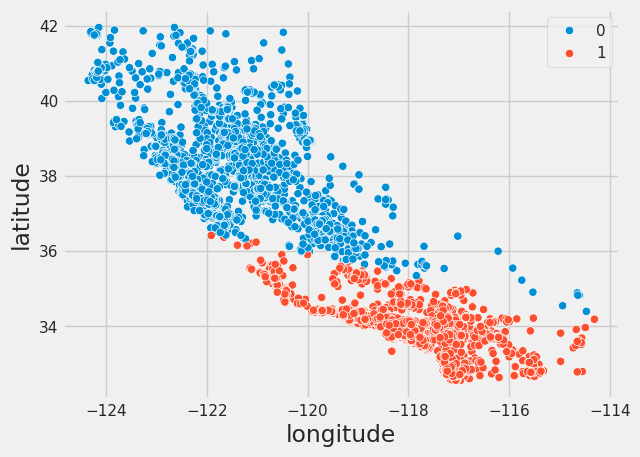

In [27]:
kmeans = KMeans(n_clusters=2, **kmeans_kwargs)
kmeans.fit(X_train_norm)

sns.scatterplot(data = X_train,
                x = 'longitude', y = 'latitude',
                hue = kmeans.labels_);

In [28]:
!pip install kneed

А если на глаз не нравится?

In [29]:
from kneed import KneeLocator

In [30]:
kl = KneeLocator(
     range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

2

Теперь посмотрим на качество кластеризации с точки зрения silhouette?

In [31]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train_norm)
    score = silhouette_score(X_train_norm, kmeans.labels_)
    silhouette_coefficients.append(score)

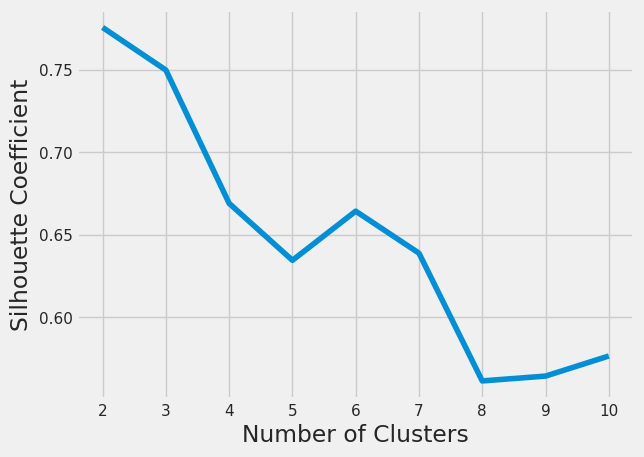

In [32]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Рекомендуется брать то число кластеров, после которого модель демонстрирует нестабильность. Однако, могут быть экспертные требования, которые позволят от этого правила отойти

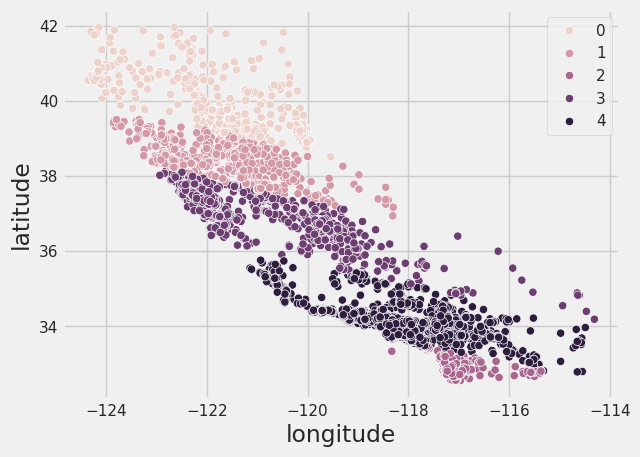

In [33]:
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(X_train_norm)

sns.scatterplot(data = X_train,
                x = 'longitude', y = 'latitude',
                hue = kmeans.labels_);

Красиво. Но смысл разбиения не особо ясен.

# DBSCAN

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [36]:
db = DBSCAN(eps=20, min_samples=5)
db.fit(X_train)

DBSCAN(eps=20)

Параметр `eps` определяет максимальное расстояние между двумя точками, чтобы они считались соседями. Если `eps` слишком мал, многие точки останутся несвязанными; если слишком велик, все точки окажутся в одном кластере.

Параметр `min_samples` определяет минимальное количество точек, необходимых для формирования плотного региона (кластера). Если `min_samples` слишком мал, многие выбросы будут классифицированы как кластеры; если слишком велик, многие кластеры не будут сформированы.

In [37]:
DB_df = X_train[['latitude', 'longitude']].copy()
DB_df['Cluster'] = db.labels_

DB_df['Cluster'].value_counts()

Cluster
0    13828
Name: count, dtype: int64

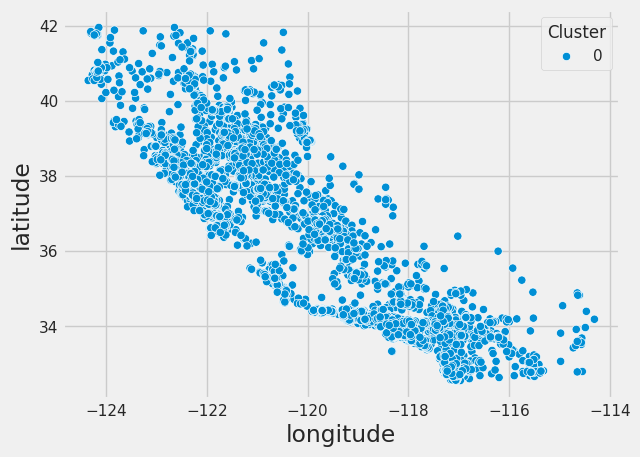

In [38]:
sns.scatterplot(data = DB_df,
                x = 'longitude', y = 'latitude',
                hue = DB_df['Cluster']);

In [39]:
from sklearn.neighbors import NearestNeighbors

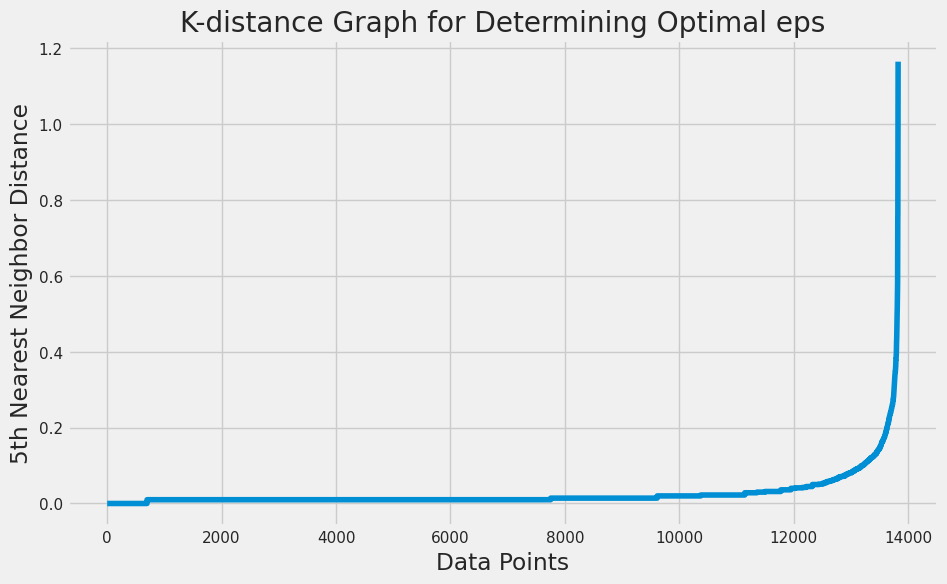

eps: 0.01, min_samples: 3, Number of clusters: 1321
eps: 0.01, min_samples: 5, Number of clusters: 719
eps: 0.01, min_samples: 7, Number of clusters: 362
eps: 0.01, min_samples: 10, Number of clusters: 135
eps: 0.01, min_samples: 20, Number of clusters: 2
eps: 0.01, min_samples: 30, Number of clusters: 0
eps: 0.01, min_samples: 40, Number of clusters: 0
eps: 0.01, min_samples: 100, Number of clusters: 0
eps: 0.1, min_samples: 3, Number of clusters: 76
eps: 0.1, min_samples: 5, Number of clusters: 59
eps: 0.1, min_samples: 7, Number of clusters: 48
eps: 0.1, min_samples: 10, Number of clusters: 43
eps: 0.1, min_samples: 20, Number of clusters: 36
eps: 0.1, min_samples: 30, Number of clusters: 31
eps: 0.1, min_samples: 40, Number of clusters: 23
eps: 0.1, min_samples: 100, Number of clusters: 10
eps: 0.2, min_samples: 3, Number of clusters: 24
eps: 0.2, min_samples: 5, Number of clusters: 20
eps: 0.2, min_samples: 7, Number of clusters: 14
eps: 0.2, min_samples: 10, Number of clusters: 1

In [40]:
# Пример данных (замените на ваши данные)
DB_df = X_train[['latitude', 'longitude']].copy()

# Подготовка данных
X = DB_df[['latitude', 'longitude']].values

# Построение графика "K расстояний"
nearest_neighbors = NearestNeighbors(n_neighbors=5)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:, 4], axis=0)  # расстояния до 5-го ближайшего соседа

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('5th Nearest Neighbor Distance')
plt.title('K-distance Graph for Determining Optimal eps')
plt.show()

# Пример тестирования различных значений параметров eps и min_samples
for eps in [0.01, 0.1, 0.2, 0.3, 0.4]:
    for min_samples in [3, 5, 7, 10, 20, 30, 40, 100]:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        db.fit(X)
        DB_df['Cluster'] = db.labels_
        n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        print(f'eps: {eps}, min_samples: {min_samples}, Number of clusters: {n_clusters}')

In [41]:
db = DBSCAN(eps=0.18, min_samples=100)
db.fit(X_train)

DBSCAN(eps=0.18, min_samples=100)

In [42]:
DB_df = X_train[['latitude', 'longitude']].copy()
DB_df['Cluster'] = db.labels_

DB_df['Cluster'].value_counts()

Cluster
 0    5819
 1    3048
-1    2422
 2    1013
 4     552
 6     491
 3     322
 5     161
Name: count, dtype: int64

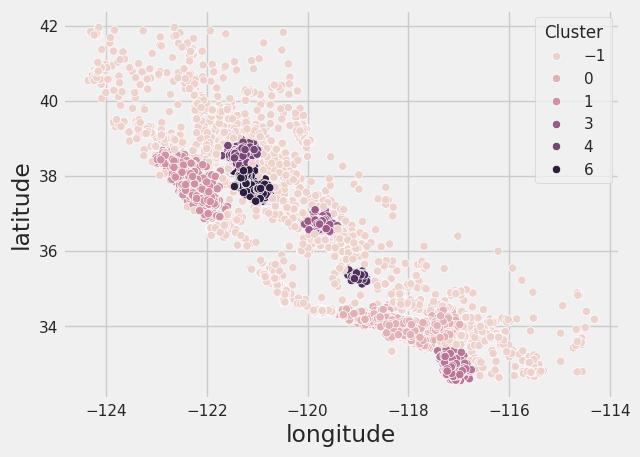

In [43]:
sns.scatterplot(data = DB_df,
                x = 'longitude', y = 'latitude',
                hue = DB_df['Cluster']);

В таком случае уже можно оценить полученные кластеры с точки зрения логики.

# Логистическая регрессия

Датасет взят из Национального института диабет и заболеваний органов пищеварения и почек. Данные предлагаются для решения задачи диагностики наличия у пациента диабета на основе  измерений.
https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [45]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/OTUS/diabetes.csv")
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


- Pregnancies - Number of times pregnant
- Glucose - Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure - Diastolic blood pressure (mm Hg)
- SkinThickness - Triceps skin fold thickness (mm)
- Insulin - 2-Hour serum insulin (mu U/ml)
- BMI - Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction - Diabetes pedigree function
- Age - Age (years)
- Outcome - Class variable (0 or 1)

In [46]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape)

(576, 8) (192, 8)


In [48]:
y.mean()

0.3489583333333333

In [49]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

In [50]:
target_names = ['without diabetes', 'with diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

                  precision    recall  f1-score   support

without diabetes       0.80      0.77      0.79       123
   with diabetes       0.62      0.65      0.63        69

        accuracy                           0.73       192
       macro avg       0.71      0.71      0.71       192
    weighted avg       0.73      0.73      0.73       192



In [51]:
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

In [58]:
y_pred_proba[:10]

array([0.271408  , 0.18791967, 0.10916592, 0.15182501, 0.47794756,
       0.44456997, 0.01409435, 0.62429125, 0.56284948, 0.78385277])

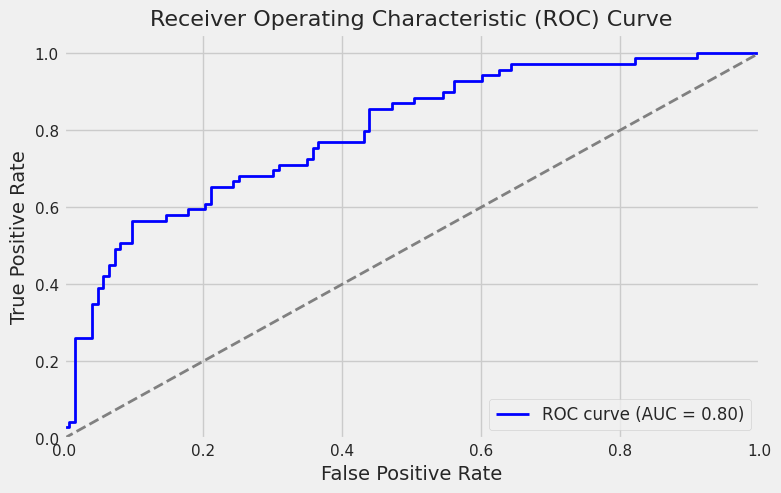

In [53]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Построение графика
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

In [54]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.3 MB/s eta 0:00:00


In [56]:
import shap

In [57]:
explainer = shap.Explainer(
    logreg, X_train, feature_names=X_train.columns
)
shap_values = explainer(X_test)

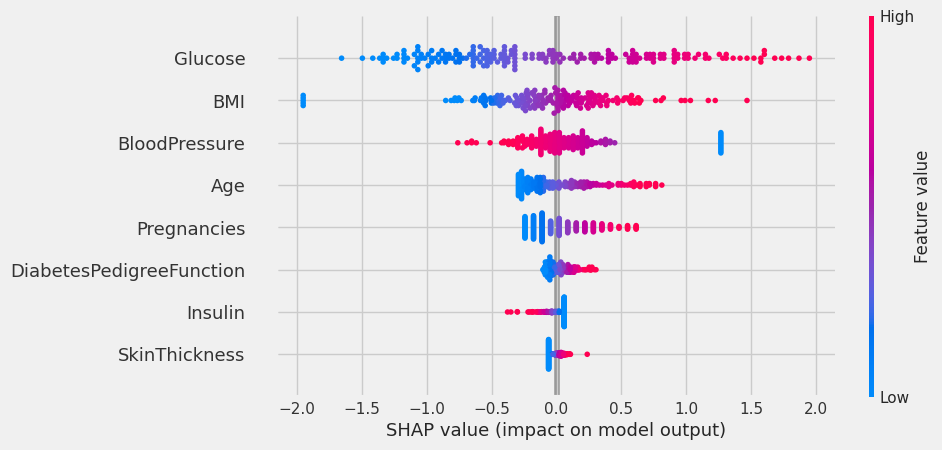

In [ ]:
shap.plots.beeswarm(shap_values)